In [5]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm
from two_opt import TwoOpt
from three_opt import ThreeOpt
from python_tsp.exact import solve_tsp_dynamic_programming
import elkai


In [6]:
class IDBA(TwoOpt, ThreeOpt):
    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        iteration: int,
        num_bats: int,
        pulse_rate: float,
        loudness: float,
        alpha:float,
        gamma:float,
        verbose: Optional[bool]):
            
        super().__init__(image,patch_size,verbose)
        self.iteration = iteration
        self.history = {i:[] for i in range(len(self.all_graphs))}
        self.num_bats = num_bats
        self.pulse_rate = pulse_rate
        self.loudness = loudness
        self.alpha = alpha
        self.gamma = gamma
        
        """
        Implementation of Improved Discrete Bat algorithm (IDBA) as described by:
        https://doi.org/10.1016/j.engappai.2015.10.006
        """

    def initialize(self,n:int,g: Dict[int, Set[int]]) -> List[List[int]]:
        """
        Initialize the initial population of grey wolves

        Arguments:
        n: number of grey wolves

        Return
        initial_population: the initial population of grey wolves
        """
        nodes = sorted(list(g.keys()))
        initial_population = [random.sample(nodes,len(g)) for i in range(n)]
        weight_matrix = self.weight_matrix[nodes][:,nodes]


        nodes = list(g.keys())
        initial_population = [random.sample(nodes,len(g)) for i in range(n)]

        # LKH
        dm = elkai.DistanceMatrix(weight_matrix)
        order = dm.solve_tsp()
        p_1 = list(np.asarray(nodes)[order[:-1]])
        initial_population[1] = p_1

        initial_pulse_rate = [self.pulse_rate]*self.num_bats
        initial_loudness = [self.loudness]*self.num_bats

        return initial_population, initial_pulse_rate, initial_loudness
    
    
    def get_fitness(self,population):
        """
        Gets the fitness of every wolf
        """
        population = population
        fitness = lambda x: len(self.build_path(x,self.adj_list,self.local_to_coords))

        return list(map(fitness,population))
    
    def get_distance(self,route):
        dist = 0
        for i in range(len(route)-1):
            dist += self.weight_matrix[route[i],route[i+1]]
            
        return dist
    

    def _optimize_one(self,i_g,g):
        population, pulse_rate, loudness = self.initialize(self.num_bats,g)

        for i in tqdm(range(self.iteration)):
            population = sorted(population, key=lambda x:len(self.build_path(x,self.adj_list,self.local_to_coords)))
            best_bat = population[0]
            best_path_dist = self.get_distance(best_bat)
            for j in range(self.num_bats):

                v_t = random.randint(0, int(distance.hamming(population[j],best_bat)*len(g))) #HD is from 0 so that random does not fail
                if v_t < self.num_vertex / 2:
                    population[j] = self.two_opt(population[j],v_t)
                else:
                    population[j] = self.three_opt(population[j],v_t)

                if random.random() > pulse_rate[j]:
                    population[j] = self.two_opt(population[j])

                if (random.random() < loudness[j]) and (self.get_distance(population[j]) < best_path_dist):
                    best_bat = population[j]
                    pulse_rate[j] = pulse_rate[j]*(1-np.exp(-self.gamma*i))
                    loudness[j] = loudness[j] * self.alpha

            all_fitness = self.get_fitness(population)
            self.history[i_g].append(all_fitness)
                
        return self.build_path(best_bat,self.adj_list,self.local_to_coords)
    
    def _optimize(self):
        self.seal_path = []
        self.traverse_path = []
        self.all_path_converted = []        

        for i, g in enumerate(self.all_graphs):
            path = self._optimize_one(i,g)
            path = self.build_path(path,self.adj_list,self.local_to_coords)
            self.seal_path.append(path)

        if len(self.seal_path) == 1:
            p = [self.mapping_r[local_node] for local_node in self.seal_path[0]]
            self.all_path_converted.append(p)
            return p        
        else:
            path = []
            path_weights, connect_paths = self.post_path(self.seal_path)
            path_weights[:,0] = 0
            crack_order, _ = solve_tsp_dynamic_programming(path_weights)

            for i in range(len(self.all_graphs)):
                path_converted = []
                path_converted = list(map(lambda x : self.mapping_r[x], self.seal_path[i]))
                self.all_path_converted.append(path_converted)

            path = []
            for i in range(len(self.all_path_converted)-1):
                path.extend(self.all_path_converted[i])
                traverse_path = connect_paths[(i,i+1)]
                path.extend(traverse_path)
                self.traverse_path.append(traverse_path)

            path.extend(self.all_path_converted[crack_order[-1]])

            return path



Preprocessing of graph completed
300


100%|██████████| 50/50 [00:01<00:00, 30.07it/s]


[58, 59, 58, 57, 117, 118, 117, 116, 176, 175, 235, 234, 294, 293, 292, 352, 351, 411, 471, 472, 532, 531, 471, 531, 530, 529, 528, 468, 467, 527, 526, 525, 524, 584, 644, 643, 583, 523, 522, 582, 642, 641, 701, 700, 760, 759, 758, 757, 756, 755, 754, 753, 693, 692, 752, 751, 691, 690, 689, 629, 628, 568, 569, 570, 571, 511, 512, 513, 514, 515, 455, 456, 457, 458, 459, 519, 520, 521, 461, 460, 459, 458, 398, 397, 457, 397, 337, 277, 217, 157, 97, 37, 38, 37, 97, 157, 217, 277, 276, 336, 396, 395, 455, 454, 514, 513, 512, 572, 571, 570, 569, 509, 508, 507, 567, 566, 506, 446, 445, 505, 445, 444, 443, 442, 441, 381, 380, 440, 380, 379, 378, 377, 317, 316, 256, 255, 315, 255, 254, 253, 193, 194, 193, 192, 132, 131, 130, 129, 128, 68, 67, 127, 126, 66, 65, 64, 4, 64, 65, 125, 124, 123, 122, 182, 181, 241, 181, 180, 240, 241, 242, 182, 183, 123, 124, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 15

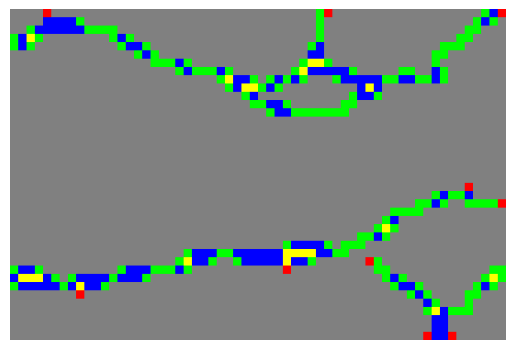

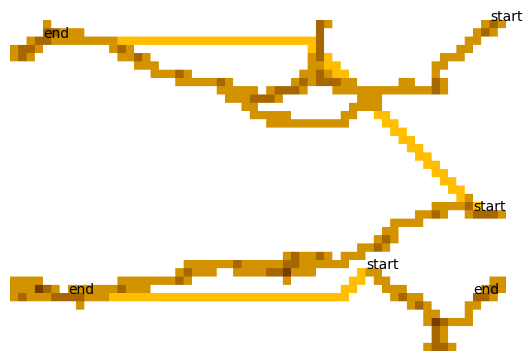

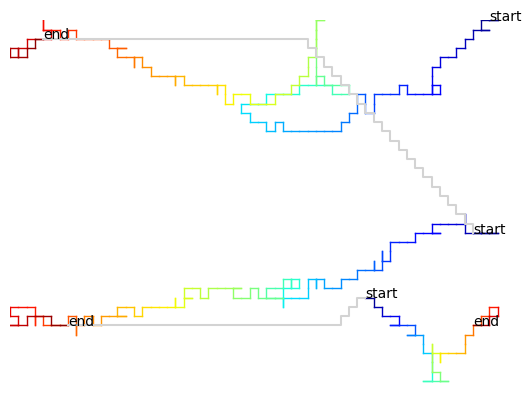

In [7]:
if __name__ == "__main__":
    num_runs = 1
    start_time = time.perf_counter()
    for i in range(num_runs):
        img = cv2.imread("./binary_image/325.png",cv2.IMREAD_UNCHANGED) 
        # img = cv2.imread("./all_cracks/Train/masks/DeepCrack_11123-2.jpg")
        # img = cv2.imread("./val_gt/val_gt/01460.png")
        if len(img.shape) == 3:
            img = np.any(img > 0, axis=-1)

        ps = (8,8)
        x = IDBA(img,ps,50,20,0.5,0.5,0.98,0.98,True)
        print(x.num_vertex)
        path = x._optimize()
        print(path)
        print(x.check_all_path())
        # x.get_statistics("Improved Discrete Grey Wolf",20,x.history)
        x.draw_path()

    end_time = time.perf_counter()
    print(f"Average time = {(end_time - start_time)/num_runs}")


Preprocessing of graph completed
405


100%|██████████| 50/50 [02:06<00:00,  2.52s/it]

[2367, 2368, 2369, 2449, 2448, 2528, 2529, 2609, 2610, 2611, 2691, 2611, 2612, 2532, 2531, 2530, 2450, 2451, 2452, 2453, 2373, 2372, 2452, 2532, 2533, 2613, 2693, 2692, 2772, 2852, 2932, 3012, 3092, 3172, 3171, 3251, 3252, 3251, 3331, 3330, 3250, 3170, 3090, 3010, 2930, 2929, 2928, 2929, 3009, 3089, 3169, 3249, 3329, 3409, 3408, 3328, 3248, 3168, 3088, 3089, 3090, 3091, 3011, 2931, 2851, 2850, 2849, 2769, 2768, 2767, 2768, 2848, 2847, 2927, 3007, 3008, 3007, 3087, 3167, 3247, 3248, 3328, 3408, 3407, 3487, 3567, 3566, 3565, 3564, 3563, 3483, 3484, 3404, 3484, 3485, 3405, 3406, 3486, 3487, 3488, 3489, 3409, 3410, 3411, 3412, 3332, 3333, 3334, 3333, 3413, 3414, 3415, 3335, 3336, 3256, 3255, 3254, 3253, 3173, 3174, 3175, 3095, 3096, 3016, 3017, 3018, 3019, 3099, 3179, 3180, 3100, 3101, 3181, 3182, 3102, 3103, 3183, 3103, 3023, 3024, 3025, 3026, 3106, 3105, 3104, 3184, 3185, 3265, 3266, 3186, 3187, 3107, 3027, 3028, 3029, 2949, 3029, 3030, 2950, 2951, 2952, 2953, 2873, 2953, 2954, 2874, 295

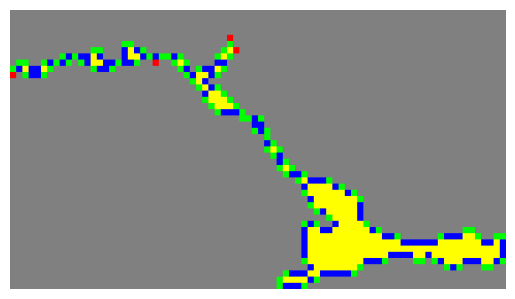

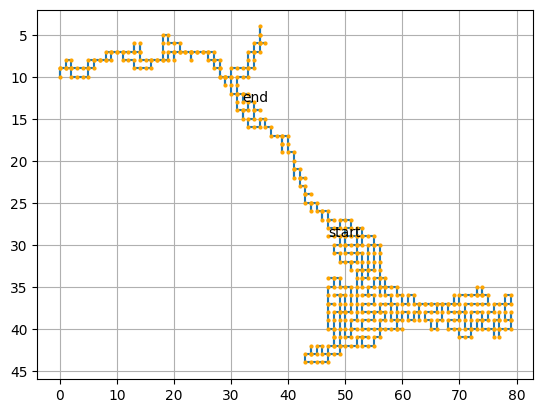

In [74]:
if __name__ == "__main__":
    num_runs = 1
    start_time = time.perf_counter()
    for i in range(num_runs):
        img = cv2.imread("./Crack500/train/mask/20160225_114503_641_361.png")
        if len(img.shape) == 3:
            img = np.any(img > 0, axis=-1)

        ps = (8,8)
        x = IDBA(img,ps,50,20,0.5,0.5,0.98,0.98,True)
        print(x.num_vertex)
        path = x._optimize()
        print(path)
        print(x.check_all_path())
        # x.get_statistics("Improved Discrete Bat Algorithm",20,x.history)
        x.draw_path()


    end_time = time.perf_counter()
    print(f"Average time = {(end_time - start_time)/num_runs}")